## Exercise 1: Bachelor study duration, comparison between boys and girls

In [286]:
#%load_ext soup
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
from os import path
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

### Data collection: get the data from IS Academia

This is the url for getting the public information from IS Academia

In [287]:
url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247"

We request the form from ISA in order to parse the necessary arguments with Beautifulsoup

In [288]:
r = requests.get(url)
isa_form = BeautifulSoup(r.text, 'html.parser')

In [289]:
request_codes = {}
for input in isa_form.find_all('select'):
    for element in input.find_all('option'):
        request_codes[element.text] = (input['name'], element['value'])

This is an example of how we can use the request codes for getting all students in bachelor semester 1 in informatics in 2007-2008

In [290]:
arguments = {}
arguments["ww_x_GPS"] = "-1"
arguments["ww_i_reportModel"] = "133685247"
arguments["ww_i_reportModelXsl"] = "133685270"
arguments[request_codes["Informatique"][0]] = request_codes["Informatique"][1]
#arguments[request_codes["2007-2008"][0]] = request_codes["2007-2008"][1]
#arguments[request_codes["Bachelor semestre 1"][0]] = request_codes["Bachelor semestre 1"][1]
arguments["ww_x_HIVERETE"] = "null"

Do all requests for 2007-2016 for both bach 1, 5 and 6 and save the data in csv format.
This also checks that if the data already exists it doesn't do the requests again.

In [291]:
semesters = [1,5,6]
files = {}
for semester in semesters:
    files[semester] = []
    
for year in range(2007,2017):
    # fill in params request: year
    y = str(year)+"-"+str(year+1)
    arguments[request_codes[y][0]] = request_codes[y][1]
    for semester in semesters:
        # fill in params request: semester
        b = "Bachelor semestre %d" % semester
        arguments[request_codes[b][0]] = request_codes[b][1]
        # do request and save to file
        filename = 'data/bachelor_%d_%d.csv' % (year, semester)
        files[semester].append(filename)
        if not path.isfile(filename):
            r = requests.get(url, params=arguments)
            table = pd.read_html(r.text, flavor='lxml', skiprows=1, header=0)[0]
            table = table.ix[:, [0,1,10]]
            table['year'] = year
            table['semester'] = semester
            table.to_csv(filename, encoding='utf-8')

### Data wrangling

Read the data from the csv files and combine them into one dataframe for each semester
The sciper number will serve as the index.

In [292]:
frames = {}
for semester in semesters:
    frames[semester] = []
    for filename in files[semester]:
        frames[semester].append(pd.read_csv(filename, header=0, encoding='utf-8', index_col=3).ix[:,1:])
    frames[semester] = pd.concat(frames[semester])

Merge the dataframes based on sciper number
This will keep only the students that have both a mention of semester 1 and semester 6. (inner join)
Students that have multiple mentions of semester 6 will appaer multiple times in the dataframe.

In [293]:
frame = pd.merge(frames[1], frames[6], left_index=True, right_index=True).ix[:, [0,1,2,6]]
frame.columns = ['	Civilité', 'Nom Prénom', 'year_sem1', 'year_sem6']
frame.head()

,Civilité,Nom Prénom,year_sem1,year_sem6
No Sciper,,,,
147008,Monsieur,Good Xavier,2008,2010
169569,Monsieur,Arévalo Christian,2007,2009
169731,Monsieur,Knecht Mathieu,2007,2010
169795,Monsieur,Scheiben Pascal,2007,2009
169795,Monsieur,Scheiben Pascal,2007,2010


We will now merge with semester 5 as well because a student can have the following path 1-2-3-4-5-6-5 and graduate after 7 semesters.

In [294]:
frame = pd.merge(frame, frames[5], left_index=True, right_index=True).ix[:, [0,1,2,3,6]]
frame.columns = ['Civilité', 'Nom Prénom', 'year_sem1', 'year_sem6', 'year_sem5']
frame = frame.drop_duplicates()
frame.head()

,Civilité,Nom Prénom,year_sem1,year_sem6,year_sem5
No Sciper,,,,,
147008,Monsieur,Good Xavier,2008,2010,2010
169569,Monsieur,Arévalo Christian,2007,2009,2009
169731,Monsieur,Knecht Mathieu,2007,2010,2010
169795,Monsieur,Scheiben Pascal,2007,2009,2009
169795,Monsieur,Scheiben Pascal,2007,2009,2010


To keep the row with the latest mention of semester 5 and semester 6, we remove the duplicates from the dataframe and only keep the last mention. The last mention will be the one with the latest year because we got the data from isa ordered by year.

In [295]:
frame = frame.groupby(frame.index).last()
frame.head()

,Civilité,Nom Prénom,year_sem1,year_sem6,year_sem5
No Sciper,,,,,
147008,Monsieur,Good Xavier,2008,2010,2010
169569,Monsieur,Arévalo Christian,2007,2009,2009
169731,Monsieur,Knecht Mathieu,2007,2010,2010
169795,Monsieur,Scheiben Pascal,2007,2010,2011
171195,Monsieur,Richter Arnaud,2007,2009,2009


Compute the number of years it took a student to graduate its bachelor.
If the last mention of this student is in sem5 of the year 2016 we assume that he did not graduate yet and delete the record.

In [296]:
def get_years(row):
    if (row.year_sem5 > row.year_sem6):
        if row.year_sem5 == 2016:
            return np.NaN
        return row.year_sem5 - row.year_sem1 + 0.5
    else:
        return row.year_sem6 - row.year_sem1 + 1

frame['duration'] = frame.apply(get_years, axis=1)
frame = frame[frame.duration.notnull()]
frame.head()

,Civilité,Nom Prénom,year_sem1,year_sem6,year_sem5,duration
No Sciper,,,,,,
147008,Monsieur,Good Xavier,2008,2010,2010,3.0
169569,Monsieur,Arévalo Christian,2007,2009,2009,3.0
169731,Monsieur,Knecht Mathieu,2007,2010,2010,4.0
169795,Monsieur,Scheiben Pascal,2007,2010,2011,4.5
171195,Monsieur,Richter Arnaud,2007,2009,2009,3.0


### General statistics about dataset

Number of boys and girls in the data set

Monsieur    345
Madame       26
Name: Civilité, dtype: int64


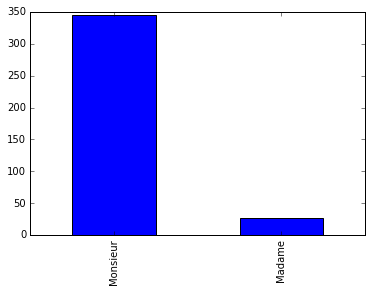

In [297]:
print(frame["Civilité"].value_counts())
frame["Civilité"].value_counts().plot(kind='bar')

Number of years it took to graduate

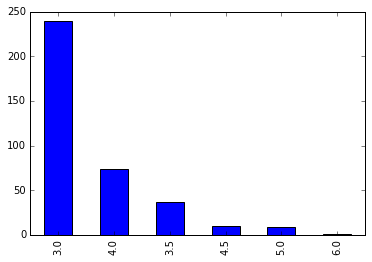

In [298]:
frame["duration"].value_counts().plot(kind='bar')

In [299]:
frame['duration'].mean()

3.3463611859838274

In [300]:
a = frame.groupby([frame.duration]).size()
a/sum(a)

duration
3.0    0.646900
3.5    0.099730
4.0    0.199461
4.5    0.026954
5.0    0.024259
6.0    0.002695
dtype: float64

In [301]:
a = frame.groupby([frame.Civilité, frame.duration]).size()
a/sum(a)

Civilité  duration
Madame    3.0         0.053908
          3.5         0.005391
          4.0         0.010782
Monsieur  3.0         0.592992
          3.5         0.094340
          4.0         0.188679
          4.5         0.026954
          5.0         0.024259
          6.0         0.002695
dtype: float64

### Comparison between boys and girls

Study duration for girls

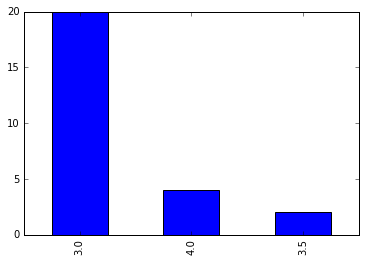

In [302]:
frame[frame.Civilité == "Madame"]['duration'].value_counts().plot(kind='bar')

In [303]:
frame[frame.Civilité == "Madame"]['duration'].mean()

3.1923076923076925

In [304]:
a = frame[frame.Civilité == "Madame"].groupby([frame.Civilité, frame.duration]).size()
a/sum(a)

Civilité  duration
Madame    3.0         0.769231
          3.5         0.076923
          4.0         0.153846
dtype: float64

Study duration for boys

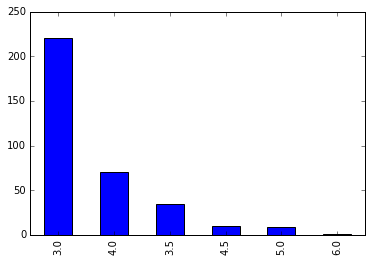

In [305]:
frame[frame.Civilité == "Monsieur"]['duration'].value_counts().plot(kind='bar')

In [306]:
frame[frame.Civilité == "Monsieur"]['duration'].mean()

3.3579710144927537

In [307]:
a = frame[frame.Civilité == "Monsieur"].groupby([frame.Civilité, frame.duration]).size()
a/sum(a)

Civilité  duration
Monsieur  3.0         0.637681
          3.5         0.101449
          4.0         0.202899
          4.5         0.028986
          5.0         0.026087
          6.0         0.002899
dtype: float64

We will perform a two-sample t-test to check if the difference in average study duration is statistically significant

In [308]:
stats.ttest_ind(a= frame[frame.Civilité == "Madame"]['duration'],
                b= frame[frame.Civilité == "Monsieur"]['duration'],
                equal_var=False)

Ttest_indResult(statistic=-2.086568428985569, pvalue=0.044622800093278688)

We obtain a value of p=0.0446. We can conclude that the difference in mean is statistically significant.